
# Import Necessary Libraries


# Import libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from natsort import natsorted # type: ignore
from sklearn.model_selection import GroupShuffleSplit
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision.models as models
import time
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import precision_score as skl_precision_score
from sklearn.metrics import recall_score as skl_recall_score
from sklearn.metrics import f1_score as skl_f1_score
from sklearn.metrics import accuracy_score as skl_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report



import random
import warnings
import shutil





# Import the code from all .py files

from custom_dataset import CustomMelanomaDataset  # Import the custom dataset
from resnet_model import ResNetModel
from preprocessing_csv import PreprocessingCSV
from train_test_loop import train_and_test
from interactive_visual_comparison import load_metadata, interactive_visual_comparison



#import torch.profiler
#from torch.utils.tensorboard import SummaryWriter
#from tensorboardX import SummaryWriter
#from torch.profiler import profile, ProfilerActivity
#import tkinter as tk
#from tkinter import filedialog, messagebox



In [4]:
warnings.filterwarnings("ignore")


In [5]:
# Define the dynamic root path
BASE_DIR = os.path.join(os.path.expanduser('~'), 'Desktop')
root_path = os.path.join(os.path.expanduser('~'), 'Desktop')


# Create the full path to the CSV file
csv_path = os.path.join(BASE_DIR, 'Thesis_Hafeez/Dataset/Train_JPEG/ISIC_2020_Training_GroundTruth.csv')

# Load the CSV file
df = pd.read_csv(csv_path)

# Display the first few rows of the dataset
print(df.head())

# Display the structure of the dataset
print(df.info())


     image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  
0   unknown           benign     0.0  
1   unknown           benign     0.0  
2     nevus           benign     0.0  
3   unknown           benign     0.0  
4   unknown           benign     0.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null 

In [22]:
# Step 1: Define the universal path handling logic
BASE_DIR = os.path.join(os.path.expanduser('~'), 'Desktop')
SPLIT_CSV_DIR = os.path.join(BASE_DIR, 'Thesis_Hafeez', 'Dataset', 'split_csv')

# Universal Path Setup for Images
IMAGE_DIR = os.path.join(BASE_DIR, 'Thesis_Hafeez', 'Dataset', 'Train_JPEG', 'JPEG')

# Paths for Train/Test CSVs
TRAIN_CSV_PATH = os.path.join(BASE_DIR, 'Thesis_Hafeez', 'Dataset', 'split_csv', 'train_split.csv')
TEST_CSV_PATH = os.path.join(BASE_DIR, 'Thesis_Hafeez', 'Dataset', 'split_csv', 'test_split.csv')

# Create the full path to the CSV file
CSV_PATH = os.path.join(root_path, 'Thesis_Hafeez/Dataset/Train_JPEG/ISIC_2020_Training_GroundTruth.csv')
new_csv_path = os.path.join(BASE_DIR, 'Thesis_Hafeez/Dataset/Train_JPEG/ISIC_2020_Training_GroundTruth_preprocess.csv')


MODEL_PATH = os.path.join(BASE_DIR, 'Thesis_Hafeez',  'Thesis_Code/Enhanced-Skin-Lesion-detection-using-Deep-Learning-model/results', 'output')

In [7]:
# Step : Create an instance of PreprocessingCSV
preprocessor = PreprocessingCSV(CSV_PATH, BASE_DIR)

# Step : Execute the preprocessing steps
preprocessor.analyze_raw_data()
preprocessor.check_for_anomalies()
preprocessor.clean_data()
preprocessor.save_clean_data()
preprocessor.split_by_patient_id()
preprocessor.verify_preprocessed_data()

Unique values in 'anatom_site_general_challenge': ['head/neck' 'upper extremity' 'lower extremity' 'torso' 'nan'
 'lower extremityi wrote to him' 'palms/soles' 'oral/genital']
Rows with variations of 'unknown':
 Empty DataFrame
Columns: [image_name, patient_id, sex, age_approx, anatom_site_general_challenge, diagnosis, benign_malignant, target]
Index: []
Unique values in 'anatom_site_general_challenge' after cleanup: ['head/neck' 'upper extremity' 'lower extremity' 'torso' 'unknown'
 'palms/soles' 'oral/genital']
NaN values in each column:
 image_name                        0
patient_id                        0
sex                              65
age_approx                       68
anatom_site_general_challenge     0
diagnosis                         0
benign_malignant                  0
target                            1
dtype: int64
Infinity values in each column:
 image_name                       0
patient_id                       0
sex                              0
age_approx    

# Define Transformations

In [8]:

# Define transforms for image augmentation and normalization
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size (224x224)
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally for data augmentation
    transforms.RandomVerticalFlip(),    # Randomly flip the image vertically
    transforms.ToTensor(),  # Convert PIL Image or numpy.ndarray to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images with pre-defined mean and std
])

# Define transformations for testing
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size (224x224)
    transforms.ToTensor(),  # Convert PIL Image or numpy.ndarray to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images with pre-defined mean and std
])


# Define train and test datasets


In [9]:
# Initialize datasets
# Create datasets
train_dataset = CustomMelanomaDataset(
    csv_file=TRAIN_CSV_PATH,
    image_dir=IMAGE_DIR,
    transform=train_transforms,
    is_test=False  # Indicates that this dataset is for training


)

test_dataset = CustomMelanomaDataset(
    csv_file=TEST_CSV_PATH,
    image_dir=IMAGE_DIR,
    transform=test_transforms,
    is_test=True  # Indicates that this dataset is for testing
)

# configs

In [10]:
# Learning parameters
lr = 1e-3
NUM_EPOCHS = 15
BATCH_SIZE = 32
num_workers=4

# Determine if CUDA is available
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PIN_MEMORY = True if torch.cuda.is_available() else False

print(f"[INFO] Using device: {DEVICE}")

[INFO] Using device: cpu


# Define dataloaders, lossFunc, Optim

In [11]:
# Create DataLoader instances
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle the data for training
    num_workers=num_workers,  # Number of workers for data loading
    pin_memory=PIN_MEMORY  # Use pin memory if using CUDA
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No need to shuffle test data
    num_workers=num_workers,  # Number of workers for data loading
    pin_memory=PIN_MEMORY  # Use pin memory if using CUDA
)

In [12]:
# Calculate steps per epoch
trainSteps = len(train_loader)
testSteps = len(test_loader)

print(f"[INFO] Training steps per epoch: {trainSteps}")
print(f"[INFO] Testing steps per epoch: {testSteps}")


[INFO] Training steps per epoch: 760
[INFO] Testing steps per epoch: 258


 # Initialize Model, Loss Function, and Optimizer

In [13]:
# Define the model, where we pass the number of metadata features (3 in this case)
num_metadata_features = 3  # Number of metadata features: sex, age, and site
model = ResNetModel(num_metadata_features).to(DEVICE)

# Loss function and optimizer
# Loss function and optimizer
pos_weight = torch.tensor([3])  # Adjust weight for handling class imbalance
lossFunc = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Learning rate scheduler


In [14]:
print(model)

ResNetModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

# Initialize Training History Dictionary

#  Training Loop Implementation with Metric Tracking and Validation

In [15]:
# Define the parameters for the training and test loop
H = train_and_test(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    lossFunc=lossFunc,
    DEVICE=DEVICE,
    NUM_EPOCHS=NUM_EPOCHS
)

# After training, we can use H for further analysis or plotting in your notebook



Epoch 1/15 running...


Testing: 100%|██████████| 258/258 [14:16<00:00,  3.32s/batch]


[INFO] EPOCH: 1/15
Train loss: 0.224211
Train Accuracy: 0.981399
Train Precision: 0.000000
Train Recall: 0.000000
Train F1 Score: 0.000000
Train ROC AUC: 0.576463
Test loss: 0.415886
Test Accuracy: 0.983475
Test Precision: 0.000000
Test Recall: 0.000000
Test F1 Score: 0.000000
Test ROC AUC: 0.470879
Test Average Precision Score: 0.018986


Epoch 2/15 running...


Testing: 100%|██████████| 258/258 [14:17<00:00,  3.32s/batch]


[INFO] EPOCH: 2/15
Train loss: 0.202939
Train Accuracy: 0.981934
Train Precision: 0.000000
Train Recall: 0.000000
Train F1 Score: 0.000000
Train ROC AUC: 0.683640
Test loss: 0.226157
Test Accuracy: 0.983475
Test Precision: 0.000000
Test Recall: 0.000000
Test F1 Score: 0.000000
Test ROC AUC: 0.615911
Test Average Precision Score: 0.024943


Epoch 3/15 running...


Testing: 100%|██████████| 258/258 [17:32<00:00,  4.08s/batch]


[INFO] EPOCH: 3/15
Train loss: 0.188931
Train Accuracy: 0.981934
Train Precision: 0.000000
Train Recall: 0.000000
Train F1 Score: 0.000000
Train ROC AUC: 0.763815
Test loss: 0.216401
Test Accuracy: 0.983475
Test Precision: 0.000000
Test Recall: 0.000000
Test F1 Score: 0.000000
Test ROC AUC: 0.714940
Test Average Precision Score: 0.054145


Epoch 4/15 running...


Testing: 100%|██████████| 258/258 [14:28<00:00,  3.37s/batch]


[INFO] EPOCH: 4/15
Train loss: 0.184532
Train Accuracy: 0.981934
Train Precision: 0.000000
Train Recall: 0.000000
Train F1 Score: 0.000000
Train ROC AUC: 0.786799
Test loss: 0.184486
Test Accuracy: 0.983475
Test Precision: 0.000000
Test Recall: 0.000000
Test F1 Score: 0.000000
Test ROC AUC: 0.763272
Test Average Precision Score: 0.046181


Epoch 5/15 running...


Testing: 100%|██████████| 258/258 [13:51<00:00,  3.22s/batch]


[INFO] EPOCH: 5/15
Train loss: 0.179648
Train Accuracy: 0.981934
Train Precision: 0.000000
Train Recall: 0.000000
Train F1 Score: 0.000000
Train ROC AUC: 0.804907
Test loss: 0.185505
Test Accuracy: 0.983475
Test Precision: 0.000000
Test Recall: 0.000000
Test F1 Score: 0.000000
Test ROC AUC: 0.732466
Test Average Precision Score: 0.044001


Epoch 6/15 running...


Testing: 100%|██████████| 258/258 [13:47<00:00,  3.21s/batch]


[INFO] EPOCH: 6/15
Train loss: 0.177449
Train Accuracy: 0.981934
Train Precision: 0.000000
Train Recall: 0.000000
Train F1 Score: 0.000000
Train ROC AUC: 0.812750
Test loss: 0.195080
Test Accuracy: 0.983475
Test Precision: 0.000000
Test Recall: 0.000000
Test F1 Score: 0.000000
Test ROC AUC: 0.754045
Test Average Precision Score: 0.057905


Epoch 7/15 running...


Testing: 100%|██████████| 258/258 [13:45<00:00,  3.20s/batch]


[INFO] EPOCH: 7/15
Train loss: 0.174656
Train Accuracy: 0.981934
Train Precision: 0.000000
Train Recall: 0.000000
Train F1 Score: 0.000000
Train ROC AUC: 0.823857
Test loss: 0.189978
Test Accuracy: 0.983475
Test Precision: 0.000000
Test Recall: 0.000000
Test F1 Score: 0.000000
Test ROC AUC: 0.764928
Test Average Precision Score: 0.048833


Epoch 8/15 running...


Testing: 100%|██████████| 258/258 [13:45<00:00,  3.20s/batch]


[INFO] EPOCH: 8/15
Train loss: 0.172627
Train Accuracy: 0.981934
Train Precision: 0.000000
Train Recall: 0.000000
Train F1 Score: 0.000000
Train ROC AUC: 0.829258
Test loss: 0.173939
Test Accuracy: 0.983475
Test Precision: 0.000000
Test Recall: 0.000000
Test F1 Score: 0.000000
Test ROC AUC: 0.800043
Test Average Precision Score: 0.064295


Epoch 9/15 running...


Testing: 100%|██████████| 258/258 [14:14<00:00,  3.31s/batch]


[INFO] EPOCH: 9/15
Train loss: 0.168848
Train Accuracy: 0.981934
Train Precision: 0.000000
Train Recall: 0.000000
Train F1 Score: 0.000000
Train ROC AUC: 0.841510
Test loss: 0.184957
Test Accuracy: 0.983475
Test Precision: 0.000000
Test Recall: 0.000000
Test F1 Score: 0.000000
Test ROC AUC: 0.773693
Test Average Precision Score: 0.055671


Epoch 10/15 running...


Testing: 100%|██████████| 258/258 [14:58<00:00,  3.48s/batch]


[INFO] EPOCH: 10/15
Train loss: 0.167433
Train Accuracy: 0.981934
Train Precision: 0.000000
Train Recall: 0.000000
Train F1 Score: 0.000000
Train ROC AUC: 0.846316
Test loss: 0.180142
Test Accuracy: 0.983475
Test Precision: 0.000000
Test Recall: 0.000000
Test F1 Score: 0.000000
Test ROC AUC: 0.799274
Test Average Precision Score: 0.070287


Epoch 11/15 running...


Testing: 100%|██████████| 258/258 [14:57<00:00,  3.48s/batch]


[INFO] EPOCH: 11/15
Train loss: 0.167063
Train Accuracy: 0.981934
Train Precision: 0.000000
Train Recall: 0.000000
Train F1 Score: 0.000000
Train ROC AUC: 0.849219
Test loss: 0.178406
Test Accuracy: 0.983475
Test Precision: 0.000000
Test Recall: 0.000000
Test F1 Score: 0.000000
Test ROC AUC: 0.799124
Test Average Precision Score: 0.069552


Epoch 12/15 running...


Testing: 100%|██████████| 258/258 [14:39<00:00,  3.41s/batch]


[INFO] EPOCH: 12/15
Train loss: 0.165483
Train Accuracy: 0.981934
Train Precision: 0.000000
Train Recall: 0.000000
Train F1 Score: 0.000000
Train ROC AUC: 0.853555
Test loss: 0.177026
Test Accuracy: 0.983475
Test Precision: 0.000000
Test Recall: 0.000000
Test F1 Score: 0.000000
Test ROC AUC: 0.802557
Test Average Precision Score: 0.074549


Epoch 13/15 running...


Testing: 100%|██████████| 258/258 [14:15<00:00,  3.32s/batch]


[INFO] EPOCH: 13/15
Train loss: 0.163080
Train Accuracy: 0.981934
Train Precision: 0.000000
Train Recall: 0.000000
Train F1 Score: 0.000000
Train ROC AUC: 0.860422
Test loss: 0.192790
Test Accuracy: 0.983475
Test Precision: 0.000000
Test Recall: 0.000000
Test F1 Score: 0.000000
Test ROC AUC: 0.792017
Test Average Precision Score: 0.071906


Epoch 14/15 running...


Testing: 100%|██████████| 258/258 [14:12<00:00,  3.30s/batch]


[INFO] EPOCH: 14/15
Train loss: 0.163404
Train Accuracy: 0.981934
Train Precision: 0.000000
Train Recall: 0.000000
Train F1 Score: 0.000000
Train ROC AUC: 0.860305
Test loss: 0.178831
Test Accuracy: 0.983475
Test Precision: 0.000000
Test Recall: 0.000000
Test F1 Score: 0.000000
Test ROC AUC: 0.802986
Test Average Precision Score: 0.071281


Epoch 15/15 running...


Testing: 100%|██████████| 258/258 [14:14<00:00,  3.31s/batch]

[INFO] EPOCH: 15/15
Train loss: 0.164581
Train Accuracy: 0.981934
Train Precision: 0.000000
Train Recall: 0.000000
Train F1 Score: 0.000000
Train ROC AUC: 0.855870
Test loss: 0.175690
Test Accuracy: 0.983475
Test Precision: 0.000000
Test Recall: 0.000000
Test F1 Score: 0.000000
Test ROC AUC: 0.801638
Test Average Precision Score: 0.071999

[INFO] Total time taken to train the model: 153271.0 seconds


In [16]:
# After the training loop ends, save the model
# Ensure the directory exists, if not, create it
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

# Define the model filename with the .pth extension
model_filename = "melanoma_trained_model.pth"

# Full path to save the model
model_save_path = os.path.join(MODEL_PATH, model_filename)

# Save the model
torch.save(model.state_dict(), model_save_path)
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /Users/hafeez/Desktop/Thesis_Hafeez/Thesis_Code/Enhanced-Skin-Lesion-detection-using-Deep-Learning-model/results/output/melanoma_trained_model.pth


# Plot the Training Metrics 

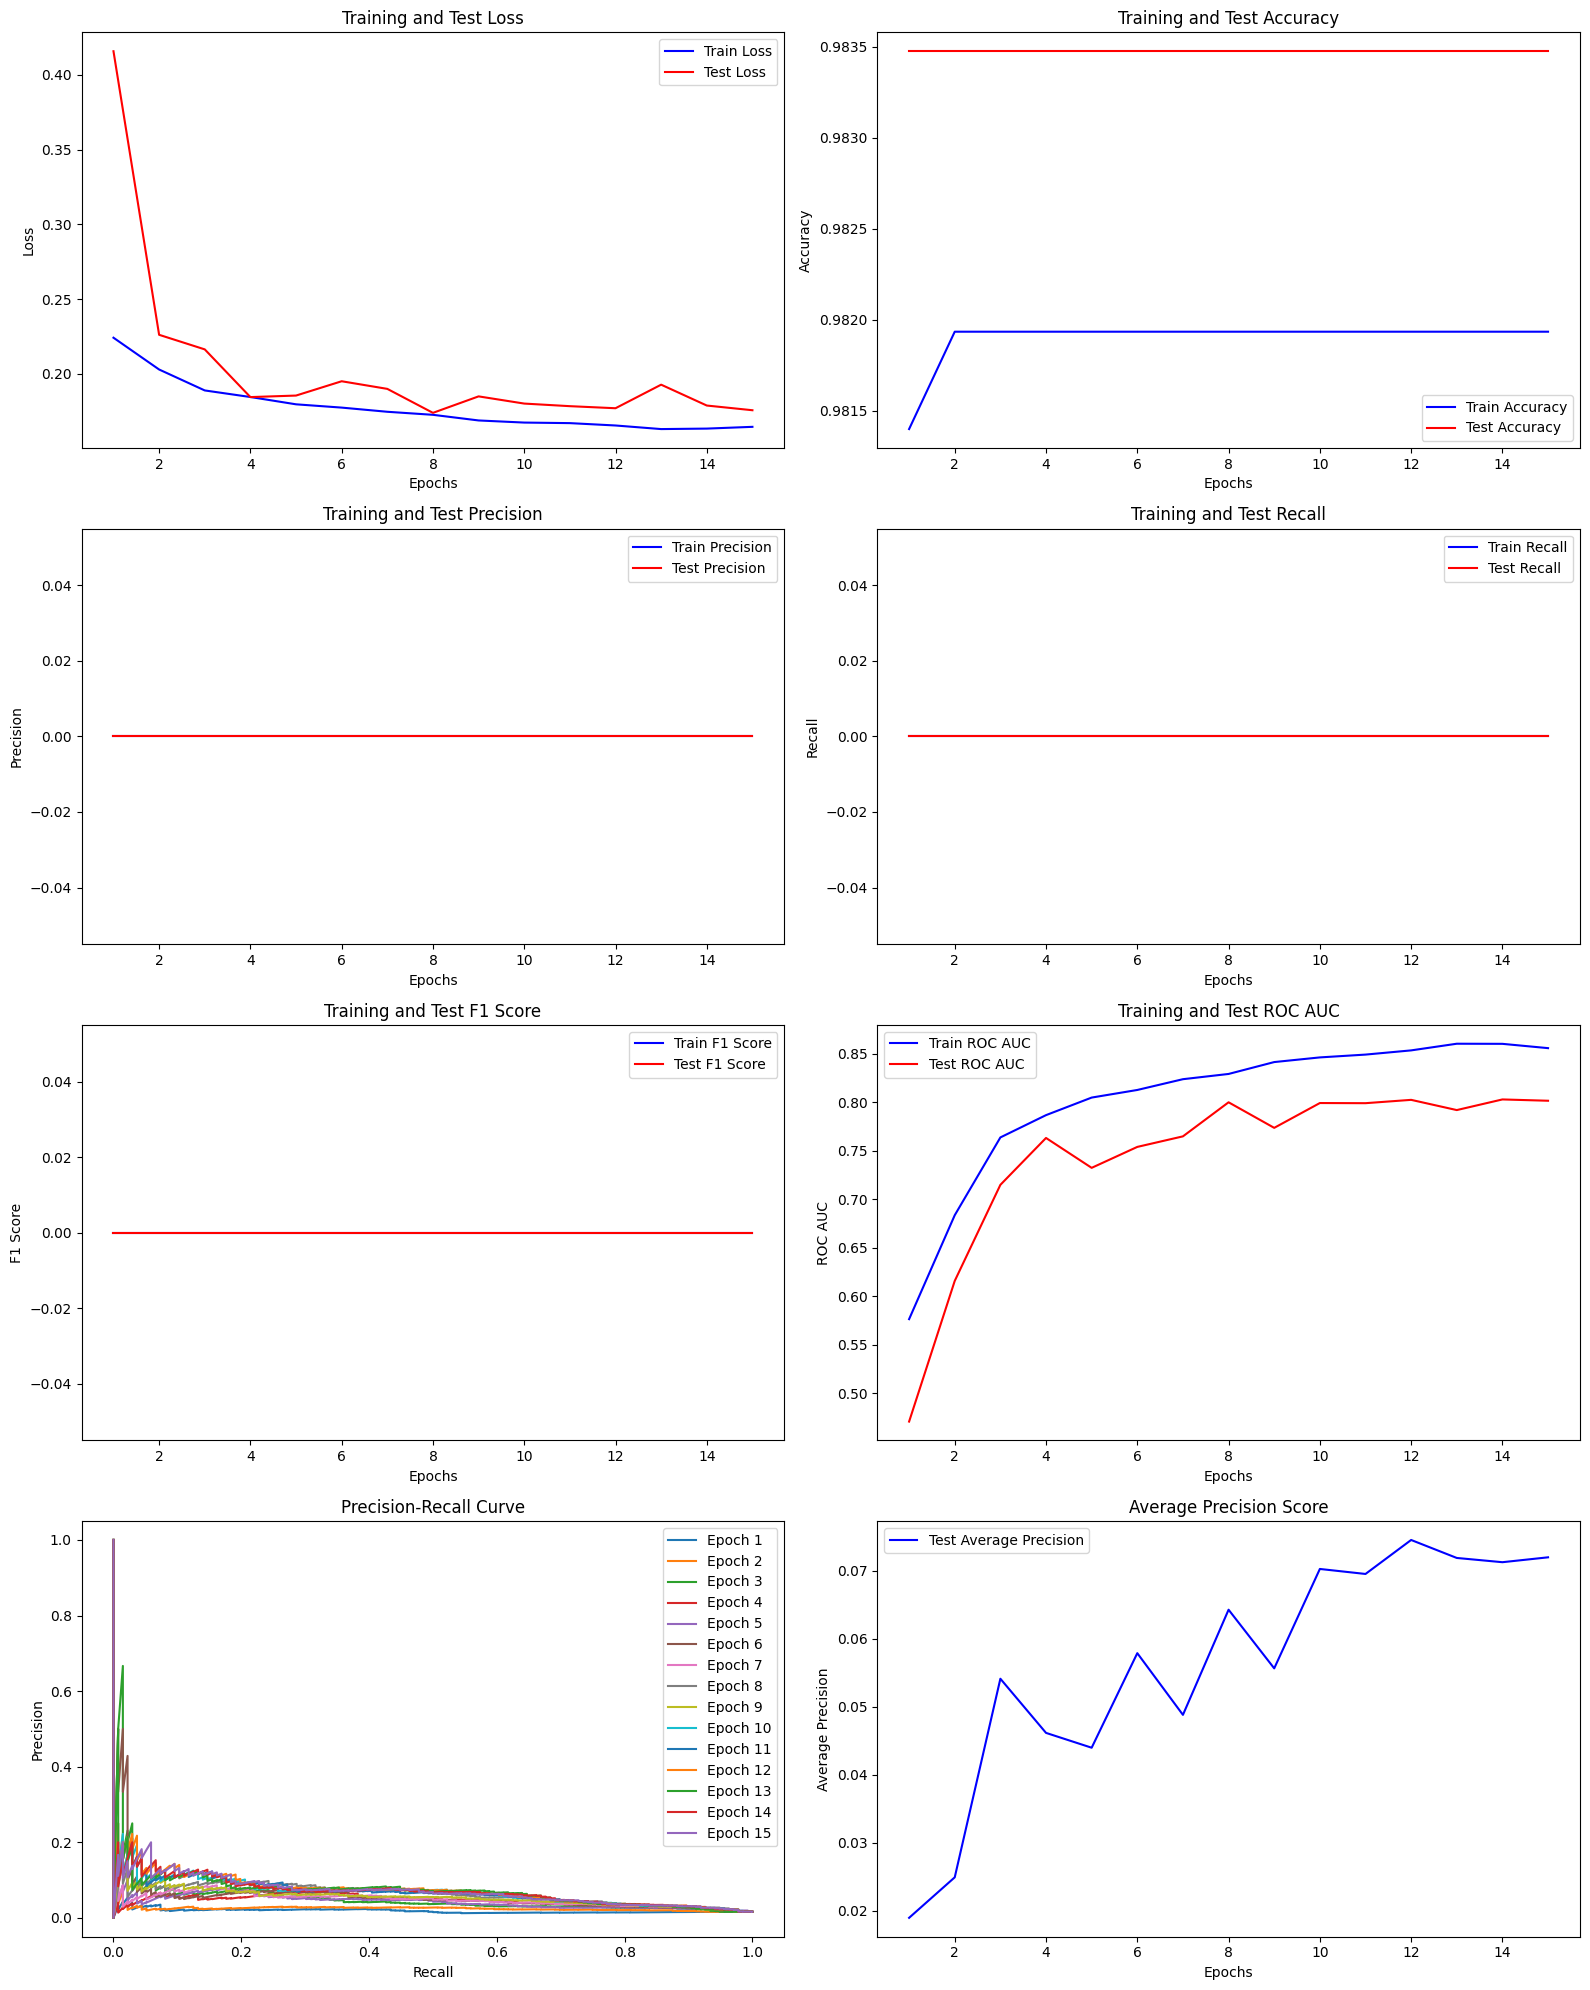

In [17]:
def plot_metrics(H):
    epochs = range(1, len(H["train_loss"]) + 1)

    plt.figure(figsize=(16, 20))

    # Plot Training and Test Loss
    plt.subplot(4, 2, 1)
    plt.plot(epochs, H["train_loss"], 'b', label='Train Loss')
    plt.plot(epochs, H["test_loss"], 'r', label='Test Loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Training and Test Accuracy
    plt.subplot(4, 2, 2)
    plt.plot(epochs, H["train_acc"], 'b', label='Train Accuracy')
    plt.plot(epochs, H["test_acc"], 'r', label='Test Accuracy')
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Training and Test Precision
    plt.subplot(4, 2, 3)
    plt.plot(epochs, H["train_precision"], 'b', label='Train Precision')
    plt.plot(epochs, H["test_precision"], 'r', label='Test Precision')
    plt.title('Training and Test Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Plot Training and Test Recall
    plt.subplot(4, 2, 4)
    plt.plot(epochs, H["train_recall"], 'b', label='Train Recall')
    plt.plot(epochs, H["test_recall"], 'r', label='Test Recall')
    plt.title('Training and Test Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    # Plot Training and Test F1 Score
    plt.subplot(4, 2, 5)
    plt.plot(epochs, H["train_f1"], 'b', label='Train F1 Score')
    plt.plot(epochs, H["test_f1"], 'r', label='Test F1 Score')
    plt.title('Training and Test F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Plot Training and Test ROC AUC
    plt.subplot(4, 2, 6)
    plt.plot(epochs, H["train_roc_auc"], 'b', label='Train ROC AUC')
    plt.plot(epochs, H["test_roc_auc"], 'r', label='Test ROC AUC')
    plt.title('Training and Test ROC AUC')
    plt.xlabel('Epochs')
    plt.ylabel('ROC AUC')
    plt.legend()

    # Plot Precision-Recall Curve
    plt.subplot(4, 2, 7)
    for i, (precision, recall) in enumerate(H["test_precision_recall_curve"]):
        plt.plot(recall, precision, label=f'Epoch {i+1}')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    # Plot Average Precision Score
    plt.subplot(4, 2, 8)
    plt.plot(epochs, H["test_average_precision"], 'b', label='Test Average Precision')
    plt.title('Average Precision Score')
    plt.xlabel('Epochs')
    plt.ylabel('Average Precision')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the metrics
plot_metrics(H)

In [18]:
 # Save the plot to the specified path
plot_filename = os.path.join(MODEL_PATH, "training_metrics_plot.png")

# Use a higher DPI for better quality
plt.savefig(plot_filename, format='png', dpi=300)  # Save the plot with higher DPI for clarity
print(f"Plot saved to {plot_filename}")
    
plt.close()  # Ensure the plot is cleared after saving to avoid showing it blank


Plot saved to /Users/hafeez/Desktop/Thesis_Hafeez/Thesis_Code/Enhanced-Skin-Lesion-detection-using-Deep-Learning-model/results/output/training_metrics_plot.png


In [19]:
# Paths for Train/Test CSVs
TRAIN_CSV_PATH = os.path.join(BASE_DIR, 'Thesis_Hafeez', 'Dataset', 'split_csv', 'train_split.csv')
TEST_CSV_PATH = os.path.join(BASE_DIR, 'Thesis_Hafeez', 'Dataset', 'split_csv', 'test_split.csv')

df_train = pd.read_csv(TRAIN_CSV_PATH)  # Load train csv dataset
df_test = pd.read_csv(TEST_CSV_PATH)  # Load test csv dataset

print("Target label count in training....")
print(df_train['target'].value_counts())  # Replace 'label_column' with the name of the column containing class labels

print("Target label count in testing....")
print(df_test['target'].value_counts())  # Replace 'label_column' with the name of the column containing class labels


Target label count in training....
target
0.0    23861
1.0      439
Name: count, dtype: int64
Target label count in testing....
target
0.0    8094
1.0     136
Name: count, dtype: int64


# interactive visual comparison


In [23]:
# Load the metadata
TEST_CSV_PATH = os.path.join(BASE_DIR, 'Thesis_Hafeez', 'Dataset', 'split_csv', 'test_split.csv')
test_metadata_df = load_metadata(TEST_CSV_PATH)

# Run the interactive visual comparison function
interactive_visual_comparison(model, test_loader, DEVICE, test_metadata_df)


IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 2000x4000 with 0 Axes>

In [24]:
import pandas as pd
import torch
import random
import matplotlib.pyplot as plt
from torchvision import transforms

# Load the test CSV to get metadata information
def load_metadata(csv_path):
    return pd.read_csv(csv_path)

# Define Function for Interactive Visual Comparison of 20 Random Images
def interactive_visual_comparison(model, test_loader, device, test_metadata_df):
    model.eval()
    all_images = []
    all_image_names = []
    all_targets = []
    all_preds = []
    transform_back = transforms.ToPILImage()

    with torch.no_grad():
        for images, metadata, targets, image_names in test_loader:
            images, metadata = images.to(device), metadata.to(device)
            targets = targets.to(device)
            
            # Make predictions
            outputs = model(images, metadata)
            preds = torch.sigmoid(outputs).round()  # Convert logits to binary predictions (0 or 1)
            
            # Store images, image names, targets, and predictions
            all_images.extend(images.cpu().detach())
            all_image_names.extend(image_names)  # Use the image names directly
            all_targets.extend(targets.cpu().detach().numpy())
            all_preds.extend(preds.cpu().detach().numpy())
    
    # Randomly select 20 samples
    indices = random.sample(range(len(all_images)), 20)
    
    plt.figure(figsize=(20, 40))
    for i, idx in enumerate(indices):
        img_name = all_image_names[idx]
        original_label = "malignant" if all_targets[idx] == 1 else "benign"
        predicted_label = "malignant" if all_preds[idx] == 1 else "benign"

        # Fetch metadata from the CSV file
        meta_row = test_metadata_df[test_metadata_df['image_name'] == img_name]

        if meta_row.empty:
            print(f"Warning: Metadata for image '{img_name}' not found.")
            benign_malignant = "unknown"
            target = -1  # Use a placeholder value for target
        else:
            benign_malignant = meta_row['benign_malignant'].values[0]
            target = int(meta_row['target'].values[0])

        # Convert image tensor back to PIL image
        img = transform_back(all_images[idx])
        
        # Plot the image and metadata
        plt.subplot(10, 2, i * 2 + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Image: {img_name}")

        # Plot metadata and prediction details
        plt.subplot(10, 2, i * 2 + 2)
        plt.axis('off')
        plt.text(0.1, 0.8, f"Original: {benign_malignant} (Target: {target})", fontsize=12)
        plt.text(0.1, 0.6, f"Predicted: {predicted_label} (Predicted Target: {int(all_preds[idx])})", fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Load the metadata
TEST_CSV_PATH = os.path.join(BASE_DIR, 'Thesis_Hafeez', 'Dataset', 'split_csv', 'test_split.csv')
test_metadata_df = load_metadata(TEST_CSV_PATH)

# Run the interactive visual comparison function
interactive_visual_comparison(model, test_loader, DEVICE, test_metadata_df)


ValueError: not enough values to unpack (expected 4, got 3)